# Neuron Model Simulations

I originally wrote this project in MATLAB as part of my Masters Program in Neuroscience, back in 2019. To explore the biophysical properties of neurons that can be harnessed for neural prosthetics e.g. Cochlea implants, we employed progressively more complex models and simulations of neurons.
I rewrote the code to Python and fitted it into this notebook as part of my portfolio. It is part of my scientific background in neuroscience and it is mainly supposed to display my style of working with data and visualization. It mainly employs Matplotlib for visualization with numpy and scipy for calculations including differential equations and linear algebra.

The main focus of this Jupyterlab book is the representation and its accompanying code. Background information can be found in my written report. 

## The very basics of how neurons work

I'm sure most people that read this don't have a neuroscience background, as such I will give a short introduction into the topic.

Neurons are a type of cell within our bodies capeable of transmitting information through the nervous system to and from our brain to orchestrate all of our behavior and bodily functions. This transfer of information relies on electrochemical and biophysical properties that we are going to explore soon.

### Semipermeable membrane and resting potential

Nerve cells are filled with fluids and they exist in a system filled with fluids. These two systems are seperated by a diffsuion barrier, a membrane. This membrane is permeable for specific, electrically charged ions (Na+, K+, Cl-), so both sides can interact with each other by exchanging ions. Some of the ions can pass freely through pores in the cells membrane, others get actively pumped through the mebrane by using energy. By systematically exchanging ions between the two systems, neurons accumulate an electrical potential that is more negative compared to the surrounding fluids. This is called the resting potential (~ -70 mV). The cell is now charged and ready to send a signal.

### Action Potential

Say you touch a hot cup of tea, how does the signal get from your hand to your brain and back again, for you to loosen your grasp?

Free nerve endings in your fingertips are capeable of sensing this potentially harmful heat and send an electrical signal via messenger molecules to the long range neurons wiring up to your brain. The exact chemical properties of transmission are not important for this project.
But ... the messenger molecules lead to a change in the potential of a cell by opening specific channels in the membrane leading to an exchange of fluids and therefore charges (Na+, K+, Cl-). This change in membrane potential can lead to a cascading effect, as the cell also has channels that open in response to changes in the electrical potential. More and more channels open, we have a big influx of positively charged ions and the neuron "spikes". It's potential rapidly jumps up and propagates through the neurons long appendix called the "axon". Once it reaches a connecting neuron this spike or "action potential" can be translated to a chemical signal and the cycle begins anew in the next cell. 
One caveat of this process is that the incoming signal needs to surpass a certain threshhold (~ -30 mV) to make a cell spike, if it doesn't reach that threshhold the cell stays silent.

Throughout the project you fill find these equivalent circuits that show a simplified version of the underlying model.

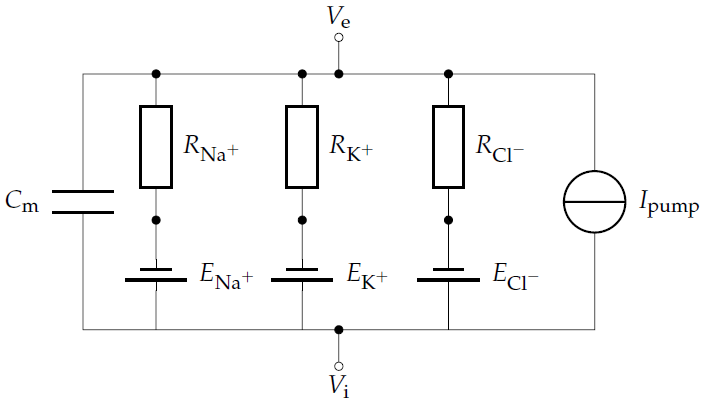

Figure 1: Resting Potential - equivalent circuit

“An equivalent circuit of the cell at resting
potential. Each ion species is represented as a
resistor and a battery. The battery represents the
ions Nernst potential while the resistor defines
how permeable the membrane is for this type of
ion. The membrane is implemented as a capacity
and the ions pumps as a simple current source.”
Hemmert, W.; Encke J. (2017) p.9


<img src="images/green-divider.png" style="width: 100%;" />


## The Leaky Integrate and Fire Model

This first, very basic model is a mere passive description of the neuron's membrane. 
By applying a steady electrical current to the "cell", the membrane potential gets progressively less negative (depolarization) up to the threshhold potential. Upon reaching the treshhold potential, the "cell" fires an action potential and repolarizes instantly.



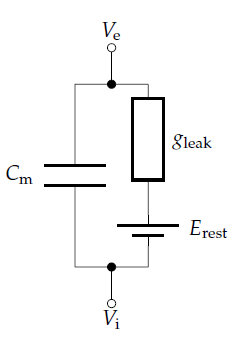

Figure 2: Leaky integrate and Fire Model - equivalent circuit

For the Leaky integrate and Fire Model, the original equivalent circuit Fig. 1 can be simplified, by replacing the batteries as well as the resistors with a combined leak
conductance \(g_{\text{{\scriptsize{leak}}}}\)
 and a battery setting the resting potential Erest. In this case, the ion pump can be dispensed with, as the
resting potential is maintained by the battery.

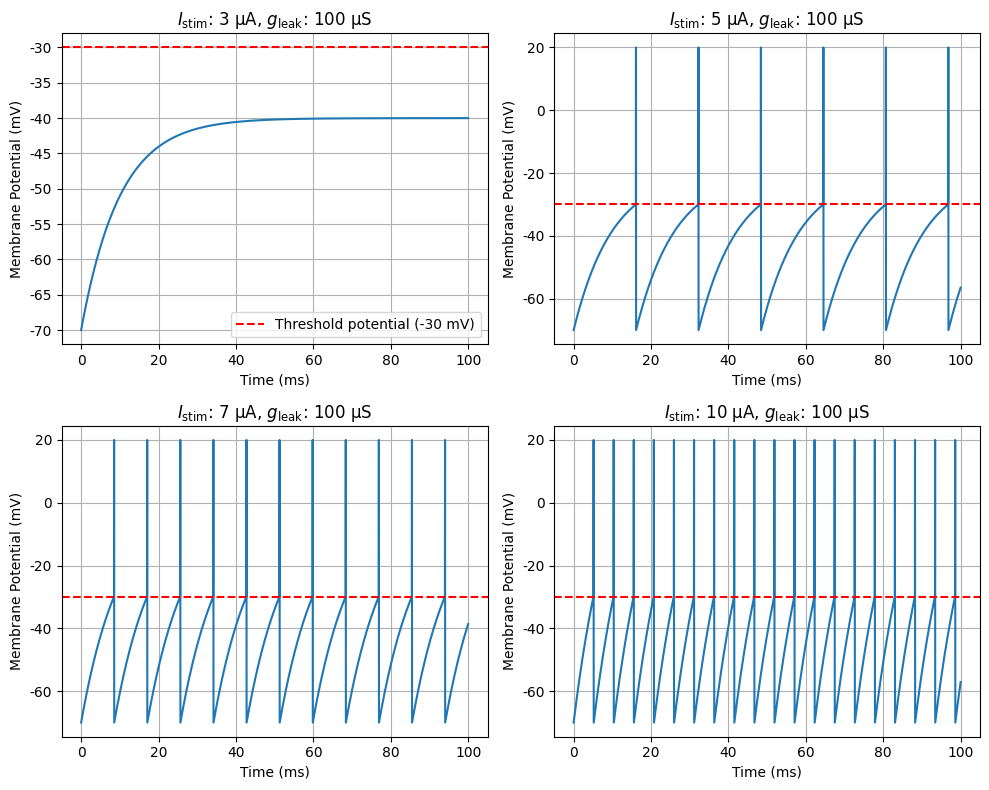

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def membrane_voltage(vm, i_stim, cm, g_leak, params):
    r = 1 / g_leak
    tau = cm * r

    for index in range(len(params["time"]) - 1):
        if vm[index] < params["v_thr"]:
            vm[index + 1] = (((-vm[index] + params["v_rest"]) / tau) + (i_stim[index] / cm)) * \
                            params["step_size"] + vm[index]
        elif vm[index] == params["v_spike"]:
            vm[index + 1] = params["v_rest"]
        elif vm[index] > params["v_thr"]:
            vm[index + 1] = params["v_spike"]

    return vm

def plot_subplot(i_stim_val, g_leak_val, ax):
    vm = np.zeros(len(params["time"]))
    vm[0] = params["v_rest"]

    i_stim = np.zeros(len(params["time"]))
    i_stim[:4999] = i_stim_val

    vm = membrane_voltage(vm, i_stim, params["cm"], g_leak_val, params)

    ax.plot(params["time"], vm)
    ax.set_xlabel("Time (ms)")  
    ax.set_ylabel("Membrane Potential (mV)")  
    ax.set_title(rf"$I_{{\mathrm{{stim}}}}$: {i_stim_val*1e6:.0f} μA, $g_{{\mathrm{{leak}}}}$: {g_leak_val*1e6:.0f} μS")  # Display units as μA and μS

    # Add threshhold value indicator
    ax.axhline(y=-0.03, linestyle="dashed", color="red", label='Threshold potential (-30 mV)')
    ax.grid()

# Function to format y-tick labels as mV
def format_mV(x, pos):
    return f"{x * 1000:.0f}"  # Convert Volts to mV and format as an integer

# Function to format x-tick labels as ms
def format_ms(x, pos):
    return f"{x * 1000:.0f}"  # Convert seconds to milliseconds and format as an integer

params = {
    "v_rest": -70e-3,
    "v_thr": -30e-3,
    "v_spike": 20e-3,
    "step_size": 30e-6,
    "cm": 1e-6,
}

params["time"] = np.arange(0, 0.1, params["step_size"])

# Create a figure with four subplots in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define different values for I_stim and g_leak
i_stim_values = [3e-6, 5e-6, 7e-6, 10e-6]
g_leak_values = [100e-6, 100e-6, 100e-6, 100e-6]

# Plot each subplot with different I_stim and g_leak values
for i in range(4):
    row, col = divmod(i, 2)
    plot_subplot(i_stim_values[i], g_leak_values[i], axs[row, col])
    
    # Add legend only for the first subplot (i == 0)
    if i == 0:
        axs[row, col].legend()

# Format y-tick labels as mV & x-tick labels as ms
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(format_mV))
    ax.xaxis.set_major_formatter(FuncFormatter(format_ms))
   

# Adjust the layout and spacing
plt.tight_layout()

plt.show()


Figure 3: Leaky integrate and fire model - static plots

Four subplots displaying different levels of stimulation current and its effect on the membrane potential. Notice that sub threshhold stimulation leads to an asymptotic membrane potential without any action potentials. Raising the stimulation current beyond that point leads to an increased frequency of action potentials.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets

# Define the parameters
params = {
    "v_rest": -70e-3,
    "v_thr": -30e-3,
    "v_spike": 20e-3,
    "step_size": 30e-6,
    "cm": 1e-6,  # Update with the correct membrane capacitance value
}

params["time"] = np.arange(0, 0.1, params["step_size"])

# Function to simulate membrane voltage
def membrane_voltage(vm, i_stim, cm, g_leak, params):
    r = 1 / g_leak
    tau = cm * r

    for index in range(len(params["time"]) - 1):
        if vm[index] < params["v_thr"]:
            vm[index + 1] = (((-vm[index] + params["v_rest"]) / tau) + (i_stim[index] / cm)) * \
                            params["step_size"] + vm[index]
        elif vm[index] == params["v_spike"]:
            vm[index + 1] = params["v_rest"]
        elif vm[index] > params["v_thr"]:
            vm[index + 1] = params["v_spike"]

    return vm

# Function to format y-tick labels as mV
def format_mV(x, pos):
    return f"{x * 1000:.0f}"  # Convert Volts to mV and format as an integer

# Function to format x-tick labels as ms
def format_ms(x, pos):
    return f"{x * 1000:.0f}"  # Convert seconds to milliseconds and format as an integer

# Create an interactive plot using widgets.interact
i_stim_slider = widgets.FloatSlider(
    value=10e-6,
    min=3, 
    max=10, 
    step=2, 
    description='Stim [μA]',
    continuous_update=False
)

def interactive_plot(i_stim_val):
    vm = np.zeros(len(params["time"]))
    vm[0] = params["v_rest"]

    i_stim = np.zeros(len(params["time"]))
    i_stim[:4999] = i_stim_val / 1_000_000  # Stimulation current in μA

    g_leak = 100e-6

    vm = membrane_voltage(vm, i_stim, params["cm"], g_leak, params)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(params["time"], vm)
    ax.axhline(y=-0.03, linestyle="dashed", color="red", label='Threshold potential (-30 mV)')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Membrane Voltage (mV)")
    ax.set_title("Leaky Integrated Fire Model")
    ax.grid()
    ax.legend()

    # Format y-tick labels as mV & x-tick labels as ms
    ax.yaxis.set_major_formatter(FuncFormatter(format_mV))
    ax.xaxis.set_major_formatter(FuncFormatter(format_ms))

    plt.tight_layout()
    plt.show()

widgets.interactive(interactive_plot, i_stim_val=i_stim_slider)


interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='Stim [μA]', max=10.0, min=3…

Figure 4: Leaky integrate and fire model - interactive plot

Depending on the system you use to view this notebook, you can see an interactive version of Figure 3 above with a slider to change the stimulation current.
You can change the stimulation current and observe the effect on the model. Notice that 3 $\mu$ A is not enough to cross the threshhold potential.


<img src="images/green-divider.png" style="width: 100%;" />


## Hodgkin-Huxley-Model

The Hodgkin-Huxley-Model is already quite complex, if you are interested in the details, please consider my written report.

### In very broad terms

This model was published in 1952 by Alan Lloyd Hodgkin und Andrew Fielding Huxley following their experiments on the giant squid axon.
It describes the biophysical properties of a neuron quite accurately by considering the voltage-gated properties of Sodium and Potassium channels as well as a leak current. By incorporating gating variables that describe the probability of a certain ion channel to be open in relation to the membrane potential H&H developed a model that accurately describes neurons to this day.




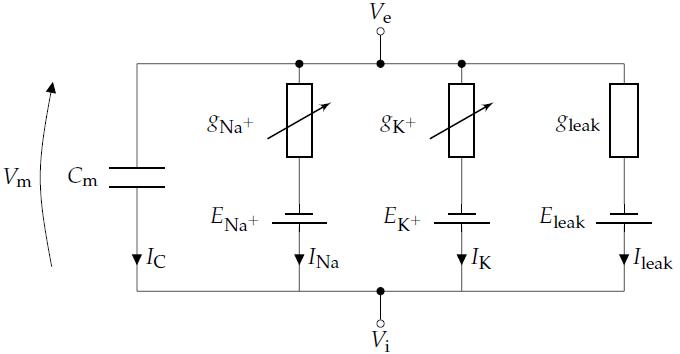

Figure 5: Hodgkin-Huxley-Model: equivalent circuit

Building upon the previous equivalent circuit. The Hodgkin-Huxley-Model introduces voltage gated ion channels implemented by voltage-dependent resistors that selectively regulate the current through the individual channel. 

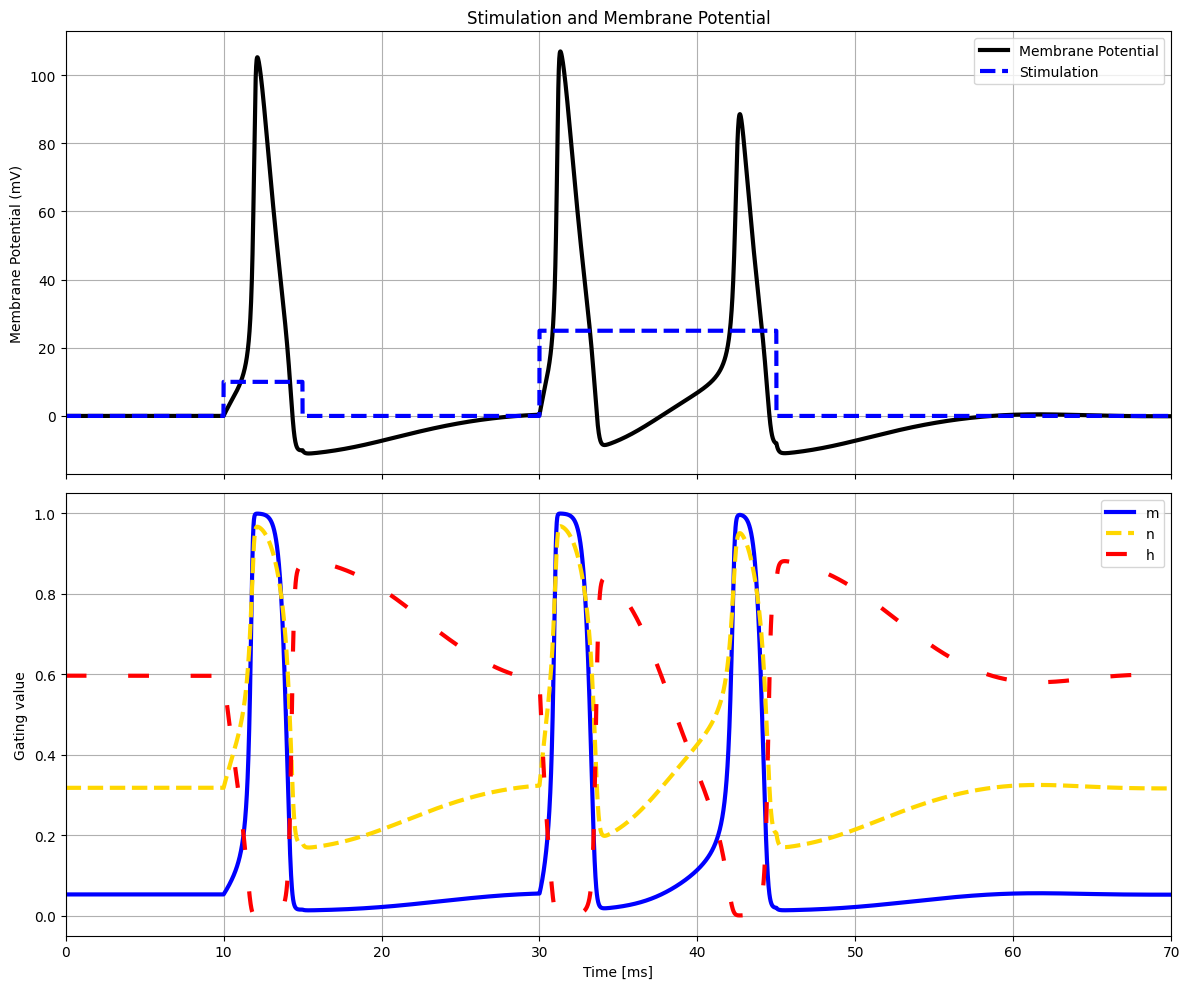

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 100.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))


# Input stimulus
def Id(t):
    if 10.0 < t < 15.0:
        return 10.0
    elif 30.0 < t < 45.0:
        return 25.0
    return 0.0


# Compute derivatives
def compute_derivatives(y, t0):
    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    dy = [
        (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy


# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

# Input stimulus
Idv = np.vectorize(Id)(T)

# Plotting
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# First subplot: Stimulation and Membrane Potential
axes1.plot(T, Vy[:, 0], color='black', label='Membrane Potential', linewidth=3)
axes1.set_ylabel('Membrane Potential (mV)')
axes1.set_title('Stimulation and Membrane Potential')
axes1.grid()
axes1.set_xlim(0, 70)
axes1.plot(T, Idv, linestyle="dashed", color="blue", label='Stimulation', linewidth=3)
axes1.legend()


# Second subplot: Membrane Potential and Gating Variable "m"
axes2.plot(T, m_inf(Vy[:, 0]), color="blue", linewidth=3, label="m")
axes2.plot(T, n_inf(Vy[:, 0]), color="gold", linewidth=3, label="n", linestyle="dashed")
axes2.plot(T, h_inf(Vy[:, 0]), color="red", linewidth=3, label="h",  linestyle=(0,(5, 10)))
axes2.set_xlabel('Time [ms]')
axes2.set_ylabel('Gating value')
axes2.grid()
axes2.legend()

plt.tight_layout()
plt.show()

Figure 6: Hodgkin-Huxley-Model - Membrane potential and gating values in response to stimulation

Top: Change of Membrane potential in reaction to stimulation current: Istim (10 – 15 ms) = 10 μA, Istim (30 – 45 ms) = 25 μA.  
Notice the refractory period (depolarization below the resting potential) after an action potential. And lower peak potential in subsequent action potential.

Bottom: m, n, and h are gating variables that represent the activation and inactivation properties of voltage-gated ion channels, specifically sodium (Na+) and potassium (K+) channels.  
m represents the activation gate for sodium (Na+) channels.  
n represents the activation gate for potassium (K+) channels.  
h represents the inactivation gate for sodium (Na+) channels.

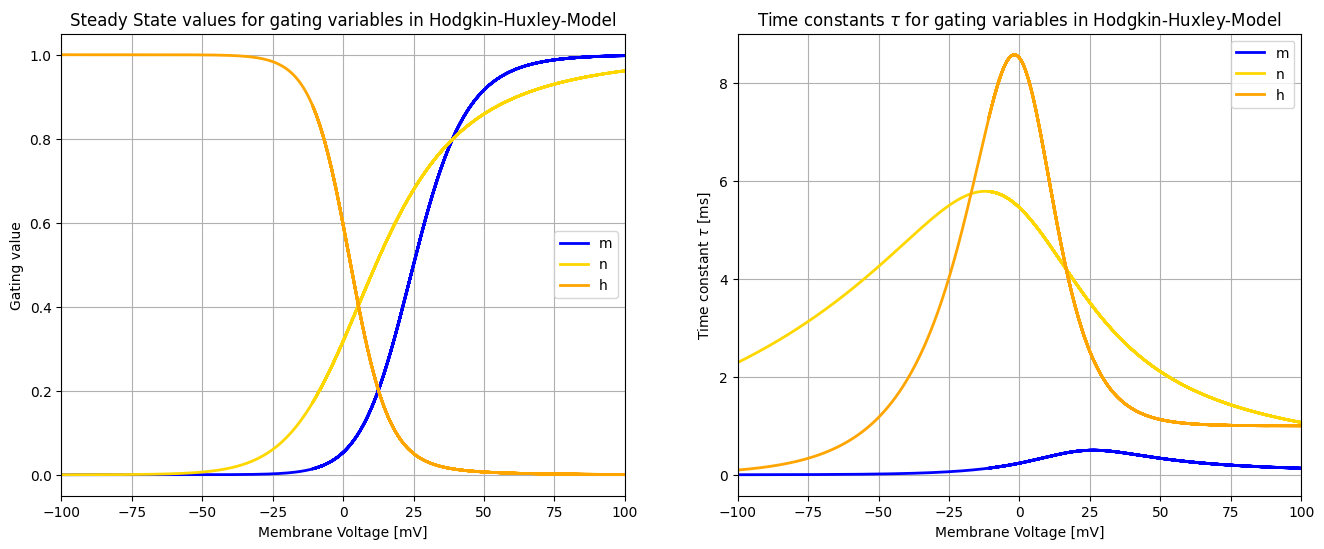

In [46]:
# Initial conditions
Y0 = [-100, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

fig, ax = plt.subplots(1,2, figsize=(16, 6))
Vm_values = Vy[:, 0]

ax[0].plot(Vm_values, m_inf(Vm_values), color="blue", linewidth=2, label="m")
ax[0].plot(Vm_values, n_inf(Vy[:, 0]), color="gold", linewidth=2, label="n")
ax[0].plot(Vy[:, 0], h_inf(Vy[:, 0]), color="orange", linewidth=2, label="h")
ax[0].set_xlabel("Membrane Voltage [mV]")
ax[0].set_ylabel("Gating value")
ax[0].set_title("Steady State values for gating variables in Hodgkin-Huxley-Model")
ax[0].set_xlim(-100,100)
ax[0].legend()
ax[0].grid()


m_time_const = (1/(alpha_m(Vm_values)+beta_m(Vm_values)))
n_time_const = (1/(alpha_n(Vm_values)+beta_n(Vm_values)))
h_time_const = (1/(alpha_h(Vm_values)+beta_h(Vm_values)))

ax[1].plot(Vm_values, m_time_const, color="blue", linewidth=2, label="m")
ax[1].plot(Vm_values, n_time_const, color="gold", linewidth=2, label="n")
ax[1].plot(Vm_values, h_time_const, color="orange", linewidth=2, label="h")

ax[1].set_xlabel("Membrane Voltage [mV]")
ax[1].set_ylabel(r"Time constant $\tau$ [ms]")
ax[1].set_title(r"Time constants $\tau$ for gating variables in Hodgkin-Huxley-Model")
ax[1].set_xlim(-100,100)
ax[1].legend()
ax[1].grid()


plt.show()


Figure 7: Hodgkin-Huxley-Model Steady state values and time constants for gating variables  

Left: Steady state values represent a state of the membrane without a change of membrane potential over time.  
As you can see when the cell is at resting potential all channels are inactivated. Depolarization leads to a rapid opening of potassium (n) and sodium (m) channels and a subsequent inactivation of sodium channels (h) to generate a sharp action potential spike.  

Right: In the context of the Hodgkin-Huxley model and ion channel dynamics in neurons, the "time constant" (τ),  for gating variables refers to the characteristic time it takes for these gating variables to change or transition between their different states in response to changes in membrane potential. The higher the time constant the more time the gating variable takes to change its conformation.




<img src="images/green-divider.png" style="width: 100%;" />


## Passive Cable Neuron Model

The previous models treated the neuron as a homogeneous electrical unit. In reality however, the cell  
consists of different areas, the soma, axons and dendrites, which can be heavily branched in  
themselves. In addition, there are different ion channel densities along the same cell. In the following  
we will describe a model that incorporates the morphological characteristics of a neuron.

Myelinization is an important part of the morphology. Myelinated axons consist of a fixed sequence  
of Ranvier nodes and myelin sheaths. Each node can be considered as a self-contained unit and the  
membrane of each unit can be modelled as an RC element and the compartments are connected via  
myelin sheaths. Since no voltage drops across the myelin-isolated membrane, this can be interpreted  
as a simple resistor.

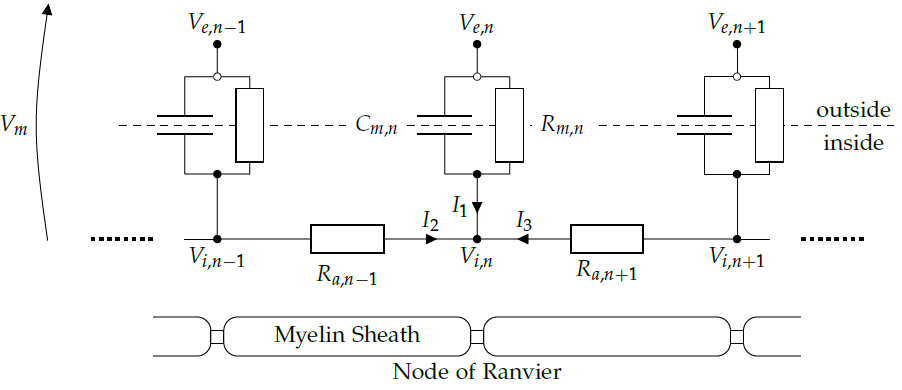

Figure 8: Passive Cable Neuron Model - equivalent circuit  
”Equivalent circuit for a short piece of axon. Each node of Ranvier is modeled as a RC element while the myelin  
sheath is modeled as a simple resistance. “Source: Hemmert, W.; Encke J. (2017) p. 26

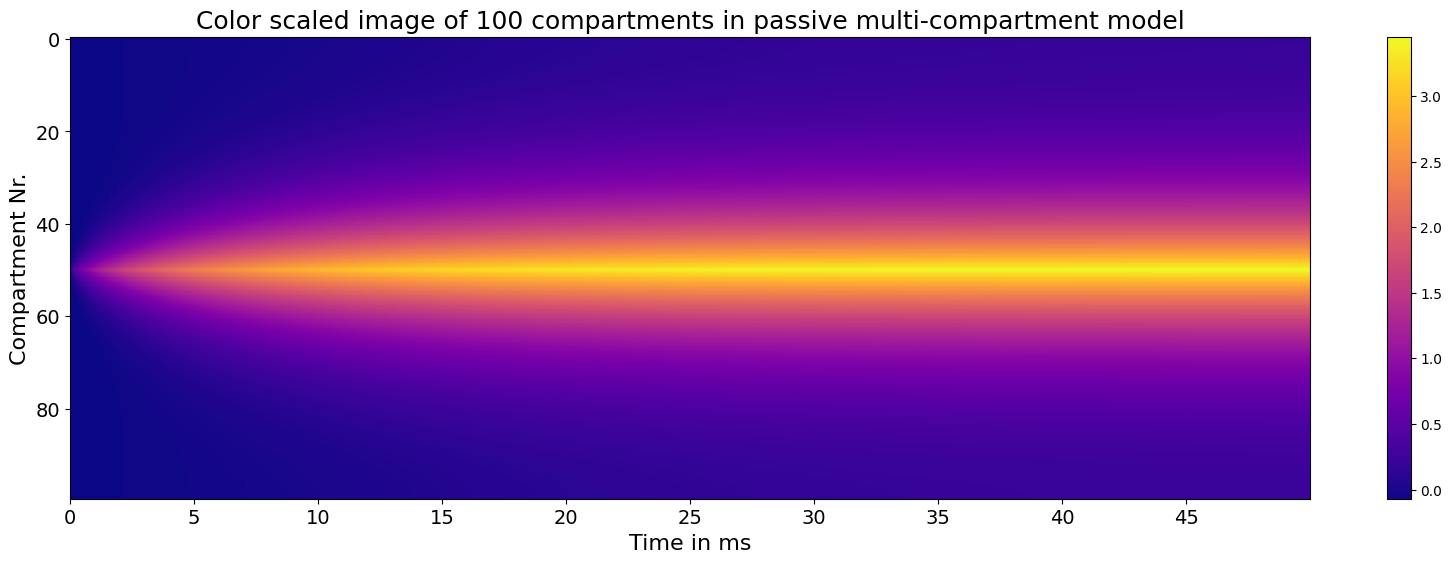

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dt = 0.01
t = np.arange(dt, 50 + dt, dt)
n = 100
Cm = 1
Rm = 10
Vm = np.ones((n, len(t))) * (-70e-3)

# Axon parameters
p = 6e-4
L = 0.1e-4
r = 2e-4
Ra = (p * L) / (np.pi * r ** 2)

# Create the capacitance matrix
c = np.ones(n) * -2
c[0] = -1
c[-1] = -1
C = np.diag(c) + np.diag(np.ones(n - 1), 1) + np.diag(np.ones(n - 1), -1)

# Build the coefficient matrix for solving the voltage
A = np.eye(n) - (dt / (Cm * Ra)) * C

# Stimulation
Istim = np.zeros((n, len(t)))
Istim[n // 2, :] = 10

# Simulate the model
for idx in range(len(t) - 1):
    Ihh = Vm[:, idx] / Rm
    b = Vm[:, idx] + (dt / Cm * (-Ihh + Istim[:, idx])).astype(np.float64)
    Vm[:, idx + 1] = np.linalg.solve(A, b)

# Calculate lambda
lambda_val = np.max(Vm[49, :]) * 0.37

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_title('Color scaled image of 100 compartments in passive multi-compartment model', fontsize=18)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.tick_params(labelsize=14)

plt.show()


Figure 9: Heatmap of Passive Cable Neuron Model (linear morphology)  
The heatmap shows an arrangement of 100 copartments with a constant excitation (10 μA) in compartment 50 and spread of excitation along the axon to neighbouring compartments.


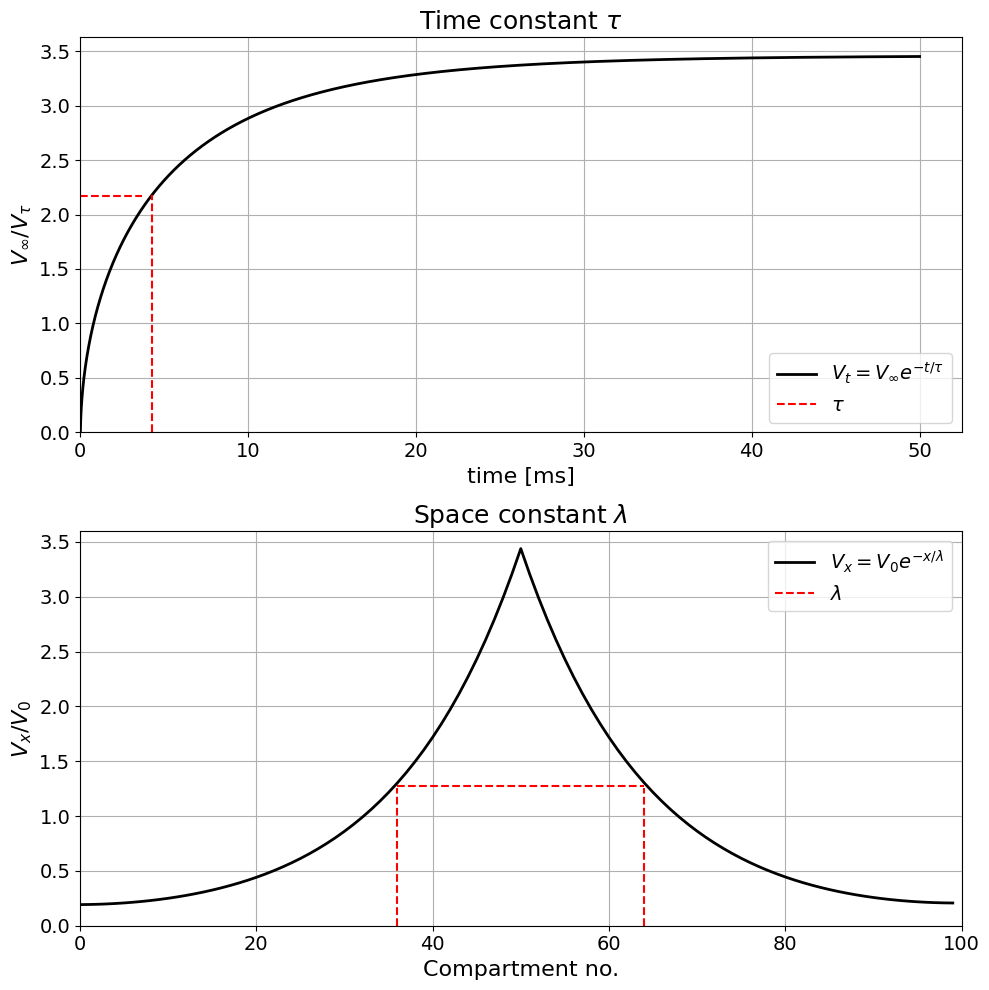

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Time constant τ
compartment_idx = 50
threshold_percent = 0.63

Vm_compartment = Vm[compartment_idx, :]
threshold_value = threshold_percent * np.max(Vm_compartment)

# Find the index where the membrane potential first exceeds the threshold
exceed_indices = np.where(Vm_compartment > threshold_value)[0]
first_exceed_index = exceed_indices[0]
threshold_time = t[first_exceed_index]

ax1.plot(t, Vm_compartment, linewidth=2, color='black', label=r"$V_t = V_\infty e^{-t/\tau}$")
ax1.set_xlabel('time [ms]', fontsize=16)
ax1.set_ylabel(r"$V_\infty/V_\tau$", fontsize=16)
ax1.set_title(r"Time constant $\tau$", fontsize=18)
ax1.set_xlim(xmin=0)
ax1.set_ylim(ymin=0)
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax1.axvline(x=threshold_time, ymax=0.6, color='red', linestyle='--', label=r"$\tau$")
ax1.axhline(y=threshold_value, xmax=0.07, color='red', linestyle='--')
ax1.legend(fontsize=14)

# Plot 2: Space constant λ
steady_state_time_idx = 3999
threshold_percent = 0.37

Vm_steady_state = Vm[:, steady_state_time_idx]
threshold_value = threshold_percent * np.max(Vm_steady_state)

# Find the index where the membrane potential first exceeds the threshold
exceed_compartment = np.where(Vm_steady_state > threshold_value)[0]

ax2.plot(Vm_steady_state, linewidth=2, color='black', label=r"$V_x = V_0 e^{-x/\lambda}$")
ax2.set_xlabel('Compartment no.', fontsize=16)
ax2.set_ylabel(r"$V_x/V_0$", fontsize=16)
ax2.set_title(r"Space constant $\lambda$", fontsize=18)
ax2.set_xlim(xmin=0, xmax=100)
ax2.set_ylim(ymin=0)
ax2.tick_params(labelsize=14)
ax2.grid(True)

ax2.axvline(x=exceed_compartment[0], color='red', ymax=0.35, linestyle='--', label=r"$\lambda$")
ax2.axvline(x=exceed_compartment[-1], color='red', ymax=0.35, linestyle='--')
ax2.axhline(y=threshold_value, xmin=0.36, xmax=0.64, color='red', linestyle='--')
ax2.legend(fontsize=14)

plt.tight_layout()
plt.show()


Figure 10: Passive membrane properties - time and space constants  

Top: The time constant of a neuron, often denoted as τ, represents the characteristic time it takes for the neuron's membrane potential to change in response to a current input.

Bottom: The space constant, denoted as λ (lambda), describes how far an electrical signal or change in membrane potential can propagate along the length of a neuron's axon or dendrites.


<img src="images/green-divider.png" style="width: 100%;" />


## Active Cable Neuron Model

In order to move from the passive model to an active one that can trigger action potentials, in the next step ion channels are added to the underlying equation.  
For this purpose all non-capacitive currents are replaced with the Hodgkin and Huxley currents from above.

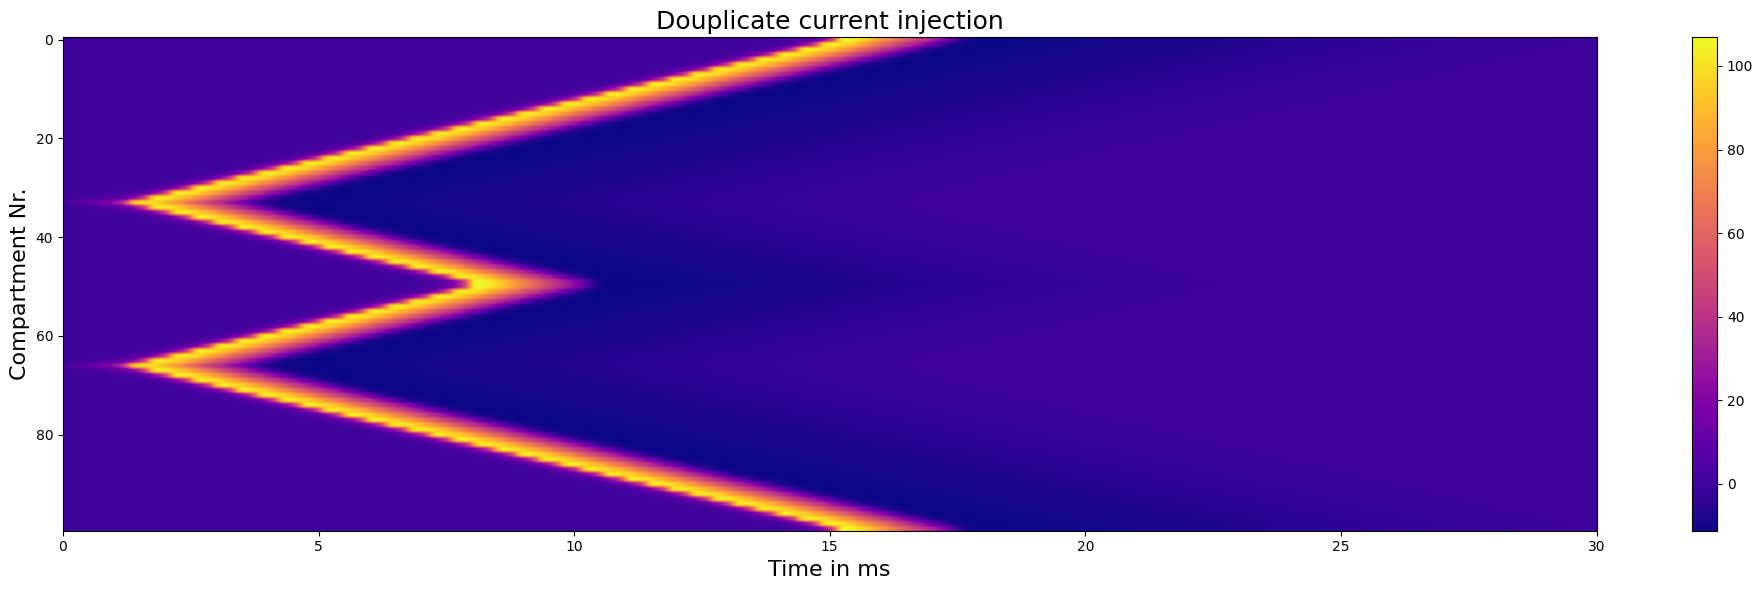

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class HHFormulas:
    def __init__(self):
        self.Vm = None
        self.dt = None
        self.k = None
        self.T = 6.3
        self.gK = 36
        self.eK = -12
        self.gNa = 120
        self.eNa = 115
        self.gL = 0.3
        self.eL = 10.6
        self.alpha_m = None
        self.alpha_n = None
        self.alpha_h = None
        self.beta_m = None
        self.beta_n = None
        self.beta_h = None
        self.tau_m = None
        self.tau_n = None
        self.tau_h = None
        self.p_m = None
        self.p_n = None
        self.p_h = None
        self.m = None
        self.n = None
        self.h = None
        self.iK = None
        self.iNa = None
        self.iL = None

    def calc_all(self):
        self.calculate_gates_and_time_constants()
        self.calculate_mnh()
        self.calculate_currents()

    def calculate_gates_and_time_constants(self):
        self.k_fcn()
        self.alpha_m_fcn()
        self.alpha_n_fcn()
        self.alpha_h_fcn()
        self.beta_m_fcn()
        self.beta_n_fcn()
        self.beta_h_fcn()
        self.tau_m_fcn()
        self.tau_n_fcn()
        self.tau_h_fcn()
        self.p_m_fcn()
        self.p_n_fcn()
        self.p_h_fcn()

    def calculate_mnh(self):
        if self.m is None:
            self.m = self.p_m
            self.n = self.p_n
            self.h = self.p_h
        else:
            self.m_fcn()
            self.n_fcn()
            self.h_fcn()

    def calculate_currents(self):
        self.ik_fcn()
        self.ina_fcn()
        self.il_fcn()

    def tau_m_fcn(self):
        self.tau_m = 1. / (self.alpha_m + self.beta_m)

    def tau_n_fcn(self):
        self.tau_n = 1. / (self.alpha_n + self.beta_n)

    def tau_h_fcn(self):
        self.tau_h = 1. / (self.alpha_h + self.beta_h)

    def p_m_fcn(self):
        self.p_m = self.alpha_m / (self.alpha_m + self.beta_m)

    def p_n_fcn(self):
        self.p_n = self.alpha_n / (self.alpha_n + self.beta_n)

    def p_h_fcn(self):
        self.p_h = self.alpha_h / (self.alpha_h + self.beta_h)

    def alpha_m_fcn(self):
        self.alpha_m = (2.5 - 0.1 * self.Vm) / (np.exp(2.5 - 0.1 * self.Vm) - 1)

    def beta_m_fcn(self):
        self.beta_m = 4 * np.exp(-self.Vm / 18)

    def alpha_n_fcn(self):
        self.alpha_n = (0.1 - 0.01 * self.Vm) / (np.exp(1 - 0.1 * self.Vm) - 1)

    def beta_n_fcn(self):
        self.beta_n = 0.125 * np.exp(-self.Vm / 80)

    def alpha_h_fcn(self):
        self.alpha_h = 0.07 * np.exp(-self.Vm / 20)

    def beta_h_fcn(self):
        self.beta_h = 1 / (np.exp((3 - 0.1 * self.Vm)) + 1)

    def m_fcn(self):
        self.m = self.m + self.dt * self.k * (self.alpha_m * (1 - self.m) - self.beta_m * self.m)

    def n_fcn(self):
        self.n = self.n + self.dt * self.k * (self.alpha_n * (1 - self.n) - self.beta_n * self.n)

    def h_fcn(self):
        self.h = self.h + self.dt * self.k * (self.alpha_h * (1 - self.h) - self.beta_h * self.h)

    def k_fcn(self):
        self.k = 3 ** (0.1 * (self.T - 6.3))

    def ik_fcn(self):
        self.iK = self.gK * self.n ** 4 * (self.Vm - self.eK)

    def ina_fcn(self):
        self.iNa = self.gNa * self.m ** 3 * self.h * (self.Vm - self.eNa)

    def il_fcn(self):
        self.iL = self.gL * (self.Vm - self.eL)


# Create an instance of the HHFormulas class
hh = HHFormulas()

# Define some parameters
hh.dt = 0.01
hh.Vm = 0

# Calculate all
hh.calc_all()

# Define parameters
g_Na = 120e-3  # conductance Sodium [ms/cm2]
g_K = 39e-3    # conductance Potassium [ms/cm2]
g_L = 0.3e-3   # conductance leak [ms/cm2]

v_Na = 115e-3   # voltage Sodium [mV]
v_K = -12e-3    # voltage Potassium [mV]
v_L = 10.6e-3   # voltage leak [mV]
v_Rest = -70e-3  # resting potential [mV]

cm = 1e-6        # membrane capacity [uF/cm2]

p_Axon = 0.1e3   # density axon [kOhm*cm]
r_Axon = 2e-4    # radius axon [cm]
L_comp = 0.1e-4  # length compartment [cm]


# time
dt = 0.01
t = np.arange(dt, 50 + dt, dt)

# compartments
n = 100

# membrane
Cm = 1
Rm = 10

# membrane voltage
Vm = np.zeros((n, len(t)))

# axon
p = 0.1        # conductance for the axon
L = 1e-6       # length for 1 compartment
r = 2e-4       # radius for the axon

# main script formula 2.43
Ra = (p * L) / (np.pi * r ** 2)  # resistance of the axon

# connectivity matrix
c = np.ones((n, 1)) * -2
c[0] = -1
c[-1] = -1

C = np.diag(c[:, 0], 0)
C = C + np.diag(np.ones(n - 1), 1)
C = C + np.diag(np.ones(n - 1), -1)

# part A from exercise_5_slides page 7/9
A = np.eye(n) - (dt / (Cm * Ra)) * C

# stimulus current
Istim = np.zeros((n, len(t)))

# Higher stimulation = more APs
Istim[n // 3, :100] = 30
Istim[n // 3 * 2, :100] = 30

for idx in range(len(t) - 1):
    # calculate all values from class hh_formula
    hh.calc_all()

    # calculate membrane current
    Im = hh.iNa + hh.iK + hh.iL

    # part b from exercise_5_slides page 7/9
    b = Vm[:, idx] + dt / (Cm * Ra) * (-Im + Istim[:, idx])

    # "x"
    Vm[:, idx + 1] = solve(A, b)
    hh.Vm = Vm[:, idx + 1]

# main script figure 2.11 top+botton
fig, ax = plt.subplots(figsize=(20, 6))

# Color scaled image of compartments
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)


ax.set_title('Douplicate current injection', fontsize=18)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.set_xlim(0, 3000)

plt.tight_layout()
plt.show()


Figure 11: Spread of excitation from two sources in an active multi compartment model.  
Notice that the injected currents spread to neighboring compartments over time.

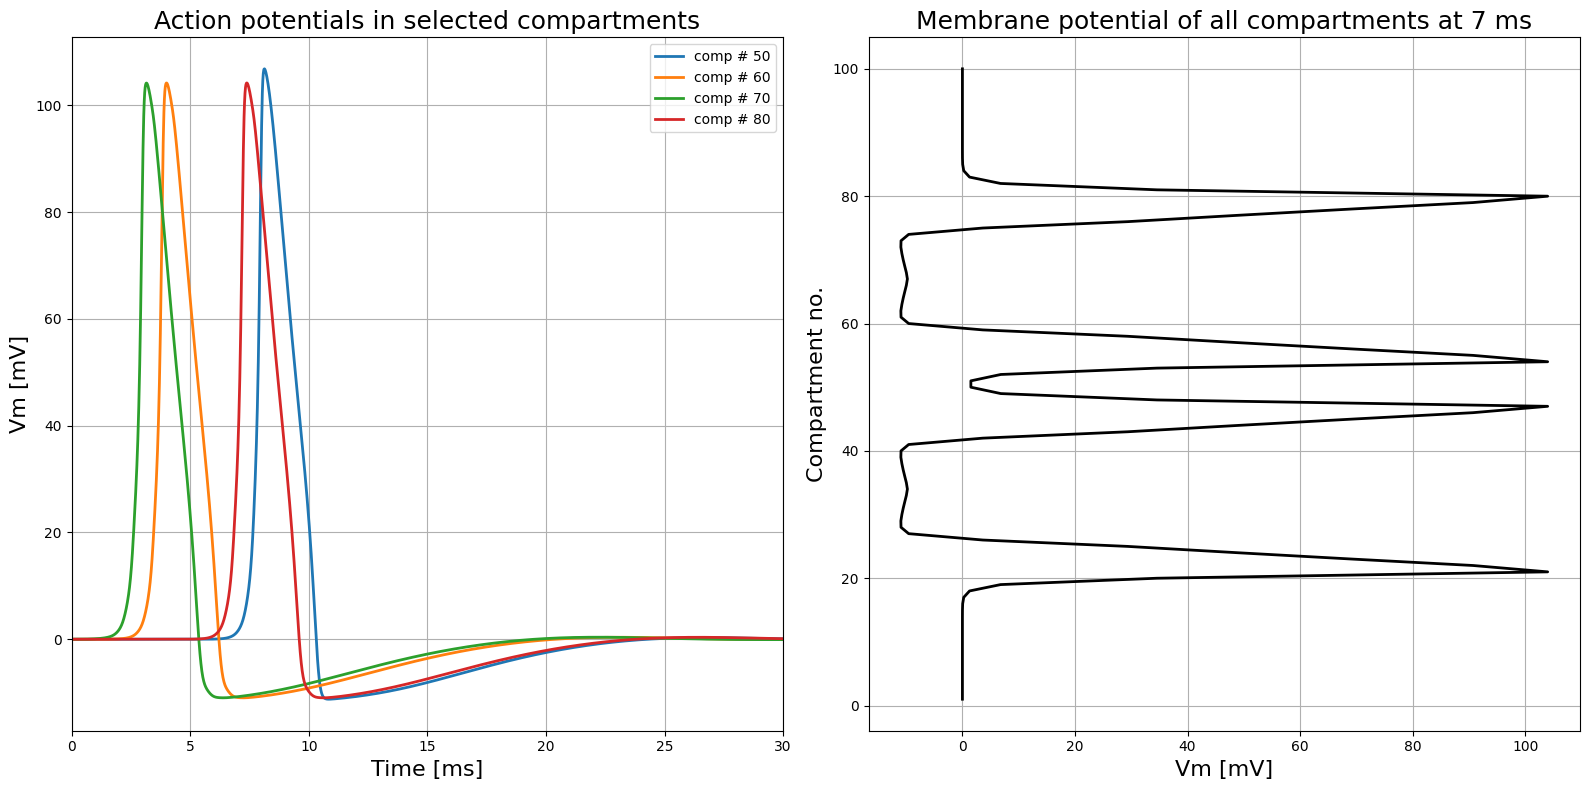

In [50]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
compartments_to_plot = [50, 60, 70, 80]
for comp in compartments_to_plot:
    plt.plot(Vm[comp, :], linewidth=2, label=f'comp # {comp}')
plt.legend()
plt.xticks(np.arange(0, len(t), len(t) // 10), np.arange(0, 50, 5))  # Use xticks to set custom tick positions and labels
plt.xlabel("Time [ms]", fontsize=16)
plt.ylabel('Vm [mV]', fontsize=16)
plt.title('Action potentials in selected compartments', fontsize=18)
plt.grid(True)
plt.xlim(0, 3000)

plt.subplot(1, 2, 2)
plt.plot(Vm[:, 700], np.arange(1, 101), linewidth=2, color='black')
plt.xlabel('Vm [mV]', fontsize=16)
plt.ylabel('Compartment no.', fontsize=16)
plt.title('Membrane potential of all compartments at 7 ms', fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.show()

Figure 12: Active cable neuron model - changes in membrane potential  
Left:Time course of action potentials being generated in four adjacent compartments (#50 to #80)  
Right: Membrane Voltage of all compartments in a given time frame (7 ms)


<img src="images/green-divider.png" style="width: 100%;" />


## Developing a cochlea implant algorithm

With this theoretical knowledge and the developed neuron models a continuous interleaved sampling
(CIS) algorithm was to be written, which imitates the acoustic process performance of a cochlear
implant. This strategy encodes speech features implicitly by accurately representing the spectro-
temporal structure of the speech signal. The basic idea of this is to divide the incoming sound into a
number of frequency bands. Extracting the temporal envelope in each band and using a compressed
version of the envelope to modulate a fixed rate-train of pulses on each electrode. These pulse trains
are eventually sent to each electrode interleaved in time to prevent unwanted interactions.

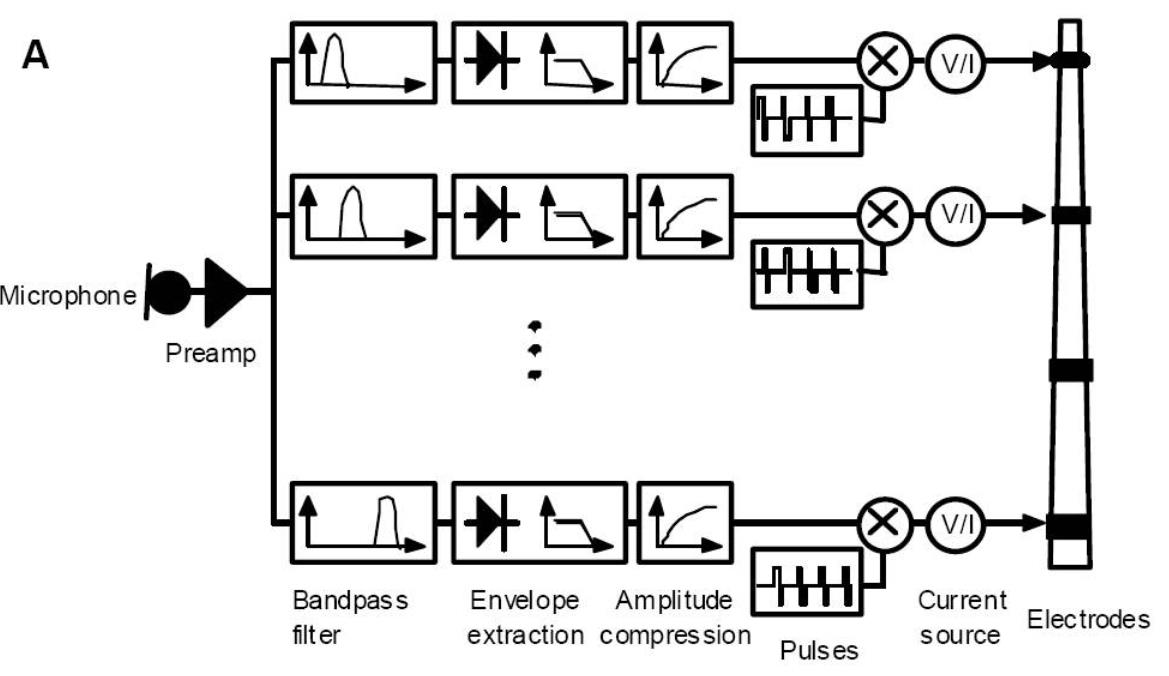

Figure 13: Block diagram and signal processing in the Continuous-Interleaved-Sampling (CIS) strategy. Source: Zeng et al. 2008  


### CIS Step 1 – Bandpass filters  
Bandpass filters are used to map the acoustic broadband signal with a limited number of electrodes.  
In the following example, frequencies below 500 Hz and above 4000 Hz were attenuated in a first step.  
Subsequently, a filter bank with 10 bandpass filters (matches the number of electrodes) evenly spaced  
between 500 and 4000 Hz was used. Since for practical reasons the electrode array cannot be inserted  
all the way to the apex of the cochlea, the choice of this filter offers a good compromise between the  
frequency presentation and the unnatural frequency to place mapping (Figure 14).  

![fig 14.png](<attachment:fig 14.png>)  

Figure 14: Visualization of the compromise between the frequency presentation and the unnatural frequency to place mapping.   
The trapezoid represents the inner ear (cochlea) which encodes for different frequencies along its axis.  

### CIS Step 2: Envelope extraction  
In CIS, only the envelope of the acoustic signal i.e. modulation of the amplitude is transmitted. This  
preserves the temporal structure of the signal, which can be used to detect vowels in low frequency  
ranges. [...]  
A population of nerve fibers all phase-locking to the same stimulus, represent in their combined  
discharge pattern the complete temporal representation of the stimulus.    

For this purpose, a low-pass filter with a cut-off frequency of 200 Hz and full wave rectification was  
used.

### CIS Step 3: Compression & conversion to current level

The envelope outputs were then compressed. This is necessary because with electrically evoked  
hearing the dynamic range is much smaller (6 - 26 dB) than with acoustic hearing (Pfingst and Xu 2004).  

### CIS step 4: generation of modulated pulse trains  

“To avoid electrode interactions caused by electrical field overlap in simultaneous stimulation, which  
conceivably can smear the band-specific envelope cues, the envelope from each subband is then  
amplitude-modulated to a high-rate (>800 Hz) pulsatile carrier that interleaves with pulsatile carriers  
from other subbands.“ (Zeng 2004)  
In other words, only one electrode is being stimulated at any given time.  

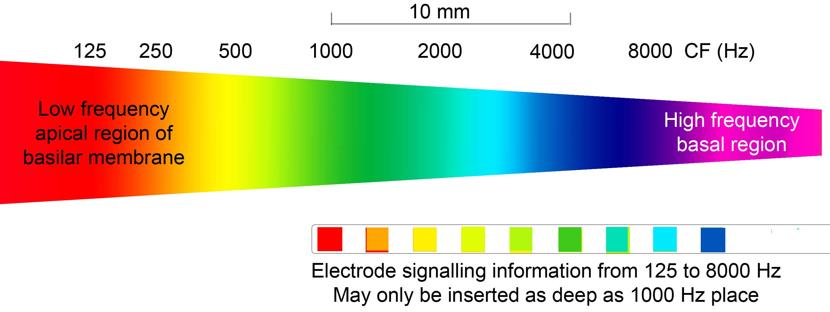

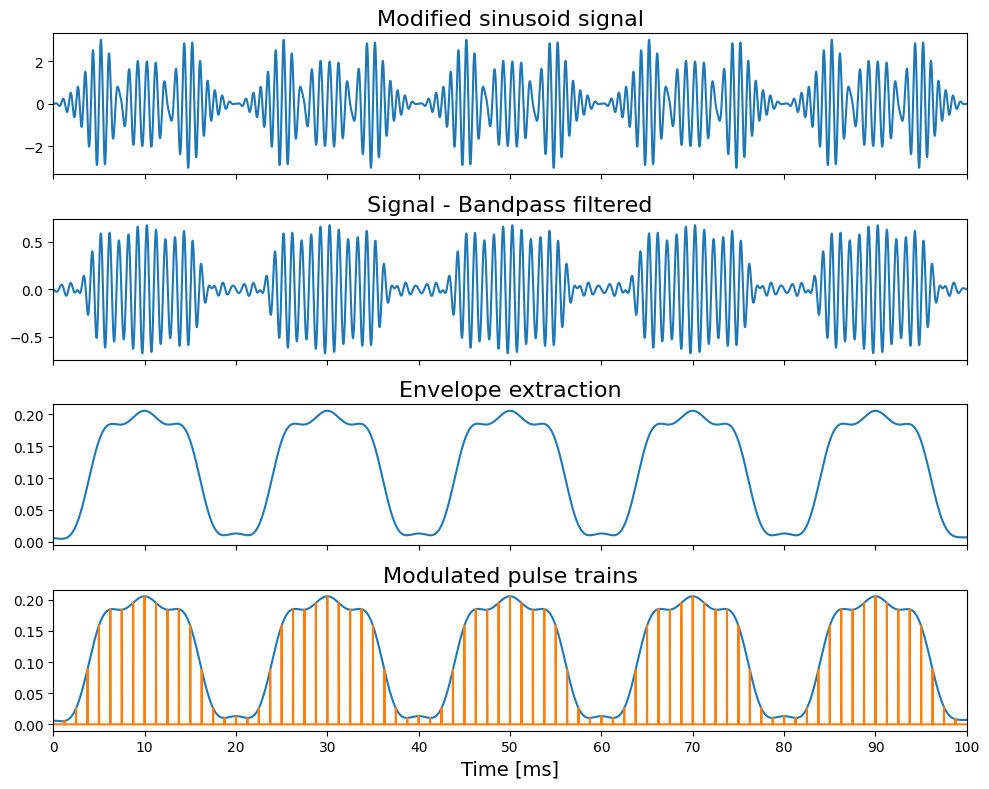

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Build signal
fs = 100000
f = 1000
f2 = 1200
duration = 100e-3  # sec
t = np.arange(0, fs * duration) / fs
signal = np.sin(2 * np.pi * t * f)
signal2 = np.sin(2 * np.pi * t * f2)
mod_sin = (1 - np.cos(2 * np.pi * t * 50))
mod_sin2 = (1 - np.cos(2 * np.pi * t * 100))
signal = signal2 * mod_sin2 + signal * mod_sin

# CIS
# Middle ear
def middle_ear(input, fs):
    order = 2
    fcut = np.array([500, 4000]) / (fs / 2)
    b, a = butter(order, fcut, btype='band')
    out = filtfilt(b, a, input)
    return out

signal = middle_ear(signal, fs)  

# Filterbank
def basilarmembran(signal_in, fs):
    # Only one channel
    signal = signal_in

    # Third octave middle frequencies from 500(-3) to 4k (6) (-1/+1 for border calculation!)
    to_f = 1000 * 2.0 ** np.arange(-4, 8) / 3.0  # Use floating-point numbers

    # Lower/upper border frequencies for the defined to_f
    band_edges = np.sqrt(to_f[:-1] * to_f[1:])

    # Cut the +1/-1
    to_f = to_f[1:-1]

    # Preallocation
    signal_out = np.zeros((len(signal_in), len(to_f)))

    # Filter order
    order = 2

    # Loop over frequency band + filter
    for idx in range(len(to_f)):
        fcut = [band_edges[idx] / (fs / 2), band_edges[idx + 1] / (fs / 2)]  # Divide each element by fs/2
        b, a = butter(order, fcut, btype='band')
        signal_out[:, idx] = filtfilt(b, a, signal)

    return signal_out

filterbank = basilarmembran(signal, fs) 

# Inner ear
def haircell(input, fs):
    cutoff = 200
    order = 4
    compress_power = 1
    
    # Initialize the output envelope
    output = np.zeros_like(input)
    
    for channel in range(input.shape[1]):
        # Half-wave rectification
        rect = np.maximum(input[:, channel], 0)
        
        # Compression
        output[:, channel] = rect ** compress_power
        
        # Lowpass filtering
        fcut = cutoff / (fs / 2)

        # Calculate the required padlen based on the filter order
        padlen = (order * 2) + 1

        # Apply the low-pass filter
        b, a = butter(order, fcut, btype='low')
        output[:, channel] = filtfilt(b, a, output[:, channel], padlen=padlen)
    
    return output


envelope = haircell(filterbank, fs)  

# Kernel
kernel_duration = 200e-6
kernel = np.concatenate((np.ones(int((kernel_duration / 2) * fs)),
                         -np.ones(int((kernel_duration / 2) * fs))))

# Only sizes
n1, n2 = envelope.shape

# PPS
pps = 800

# Period duration in samples
T = round(fs / pps)

# Dirac train (no zero at the first entry!)
pulses = np.zeros(n1)
pulses[range(T - 1, n1, T)] = 1

# Preallocation
final_stim = np.zeros((n1, n2))

for idx in range(n2):
    # Delay for the different electrodes
    phase = 1 / pps * idx / n2
    phase_samples = round(fs * phase)

    # Sampled envelope
    sampled_envelope = pulses * envelope[:, idx]

    # Add the delay
    stim_plus_phase = np.concatenate((np.zeros(phase_samples), np.convolve(sampled_envelope, kernel)))

    # Cut the stim to the right length
    final_stim[:, idx] = stim_plus_phase[:n1]



# Generate modulated pulse trains with a frequency of 800 Hz
def generate_modulated_pulse_trains(fs, duration, pps):
    t = np.arange(0, duration, 1/fs)
    pulse_train = np.zeros(len(t))
    pulse_period = int(fs / pps)
    pulse_train[::pulse_period] = 1
    return pulse_train

# Generate modulated pulse trains for each channel
pps = 800
modulated_pulse_trains = [generate_modulated_pulse_trains(fs, duration, pps) for _ in range(n2)]

# Fit the modulated pulse trains to the envelope
modulated_stim = np.zeros((n1, n2))
for idx in range(n2):
    modulated_stim[:, idx] = modulated_pulse_trains[idx][:n1] * envelope[:, idx]

# Adapt the stimulus from Pascal to μA
final_stim = modulated_stim * 700  # μA

# Plot the results
plt.figure(1, figsize=(10, 8))

# Create subplots with shared x-axis
ax1 = plt.subplot(4, 1, 1)
plt.plot(signal)
plt.title("Modified sinusoid signal", fontsize=16)

ax2 = plt.subplot(4, 1, 2, sharex=ax1)
plt.plot(filterbank[:, 4])
plt.title("Signal - Bandpass filtered", fontsize=16)

ax3 = plt.subplot(4, 1, 3, sharex=ax1)
plt.plot(envelope[:, 4])
plt.title("Envelope extraction", fontsize=16)

ax4 = plt.subplot(4, 1, 4, sharex=ax1)
plt.plot(envelope[:, 4])
plt.plot(modulated_stim[:, 4])
plt.title("Modulated pulse trains", fontsize=16)

# Remove x-axis labels from upper plots
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.xlabel('Time [ms]', fontsize=14)  # Label only the bottom subplot
plt.xlim(0, 10_000)

# Create a custom x-axis label for milliseconds
ax4.set_xticks(np.arange(0, 10_001, 1000))
ax4.set_xticklabels(np.arange(0, 101, 10))

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

Figure 15: Visualization of continous interleaved sampling (CIS) steps  
1 - Bandpass filtered [500, 4000] Hz self-generated audio signal (modified sinusoid).    
2 - 10 evenly distributed bandpass filters between 500 and 4000 Hz were applied.  
3 - Envelope of the signal.  
4 - Modulated pulse trains with a frequency of 800 Hz fitted to the envelope.  

## CIS - Single neuron

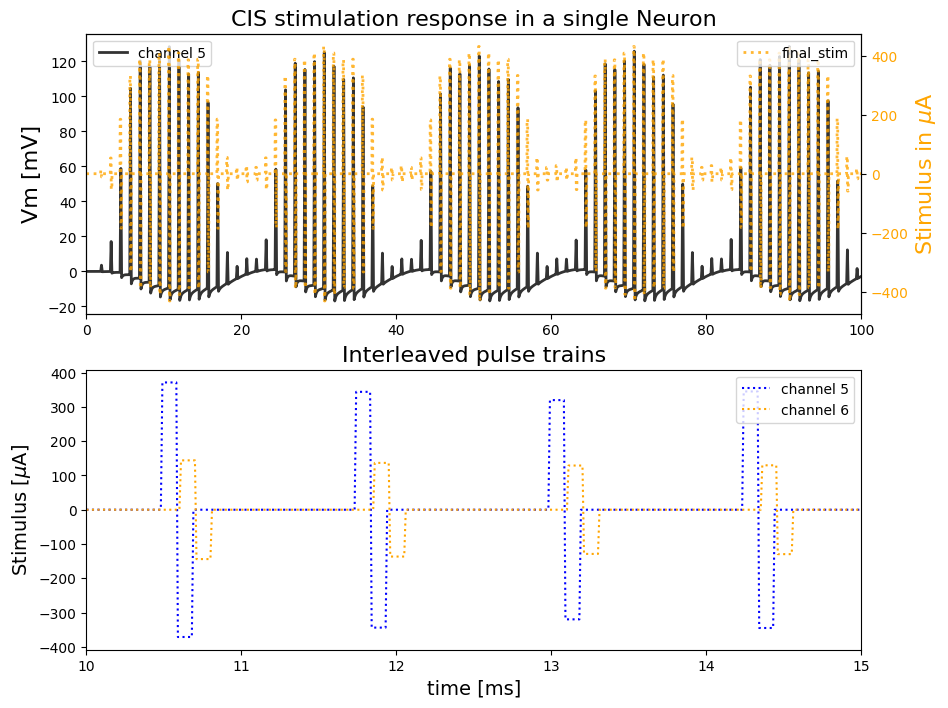

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, convolve
from scipy.integrate import odeint

# Build signal
fs = 100_000 # sampling frequency
f = 1000
f2 = 1200
duration = 100e-3  # 100 ms
t = np.arange(0, fs * duration) / fs
signal = np.sin(2 * np.pi * t * f)
signal2 = np.sin(2 * np.pi * t * f2)
mod_sin = (1 - np.cos(2 * np.pi * t * 50))
mod_sin2 = (1 - np.cos(2 * np.pi * t * 100))
signal = signal2 * mod_sin2 + signal * mod_sin

# Time parameters
dt = 0.01  # Time step (ms)
t_max = 100.0  # Maximum simulation time (ms)
num_steps = int(t_max / dt)

# Initialize variables
t = np.arange(0, t_max, dt)

# CIS
# Middle ear
def middle_ear(input, fs):
    order = 2
    fcut = np.array([500, 4000]) / (fs / 2)
    b, a = butter(order, fcut, btype='band')
    out = filtfilt(b, a, input)
    return out

signal = middle_ear(signal, fs)  

# Filterbank
def basilarmembran(signal_in, fs):
    # Third octave middle frequencies from 500(-3) to 4k (6) (-1/+1 for border calculation!)
    to_f = 1000 * 2.0 ** np.arange(-4, 8) / 3.0  # Use floating-point numbers

    # Lower/upper border frequencies for the defined to_f
    band_edges = np.sqrt(to_f[:-1] * to_f[1:])

    # Cut the +1/-1
    to_f = to_f[1:-1]

    # Preallocation
    signal_out = np.zeros((len(signal_in), len(to_f)))

    # Filter order
    order = 2

    # Loop over frequency band + filter
    for idx in range(len(to_f)):
        fcut = [band_edges[idx] / (fs / 2), band_edges[idx + 1] / (fs / 2)]  # Divide each element by fs/2
        b, a = butter(order, fcut, btype='band')
        signal_out[:, idx] = filtfilt(b, a, signal_in)

    return signal_out

filterbank = basilarmembran(signal, fs) 

# Inner ear
def haircell(input, fs):
    cutoff = 200
    order = 4
    compress_power = 1
    
    # Initialize the output envelope
    output = np.zeros_like(input)
    
    for channel in range(input.shape[1]):
        # Half-wave rectification
        rect = np.maximum(input[:, channel], 0)
        
        # Compression
        output[:, channel] = rect ** compress_power
        
        # Lowpass filtering
        fcut = cutoff / (fs / 2)

        # Calculate the required padlen based on the filter order
        padlen = (order * 2) + 1

        # Apply the low-pass filter
        b, a = butter(order, fcut, btype='low')
        output[:, channel] = filtfilt(b, a, output[:, channel], padlen=padlen)
    
    return output

envelope = haircell(filterbank, fs)  

# Kernel
kernel_duration = 200e-6
kernel = np.concatenate((np.ones(int((kernel_duration / 2) * fs)),
                         -np.ones(int((kernel_duration / 2) * fs))))

# Only sizes
n1, n2 = envelope.shape

# PPS
pps = 800

# Period duration in samples
T = round(fs / pps) # 125

# Dirac train (no zero at the first entry!)
pulses = np.zeros(n1)
pulses[range(T - 1, n1, T)] = 1

# Preallocate final_stim
final_stim = np.zeros((n1, n2))

for idx in range(1, n2 + 1):
    # Delay for the different electrodes
    phase = (1 / pps) * idx / n2
    phase_samples = int(fs * phase)
    
    # Sampled envelope
    sampled_envelope = pulses * envelope[:, idx - 1]  # Adjust for 0-based indexing
    
    # Add the delay
    stim_plus_phase = np.concatenate((np.zeros(phase_samples), convolve(sampled_envelope, kernel)))

    # Cut the stim to the right length
    final_stim[:, idx - 1] = stim_plus_phase[0: n1]

# Generate modulated pulse trains with a frequency of 800 Hz
def generate_modulated_pulse_trains(fs, duration, pps):
    t = np.arange(0, duration, 1/fs)
    pulse_train = np.zeros(len(t))
    pulse_period = int(fs / pps)
    pulse_train[::pulse_period] = 1
    return pulse_train

# Generate modulated pulse trains for each channel
modulated_pulse_trains = [generate_modulated_pulse_trains(fs, duration, pps) for _ in range(n2)]

# Fit the modulated pulse trains to the envelope
modulated_stim = np.zeros((n1, n2))
for idx in range(n2):
    modulated_stim[:, idx] = modulated_pulse_trains[idx][:n1] * envelope[:, idx]


# Adapt the stimulus from Pascal to μA
final_stim = final_stim * 700  # μA

# Hodgkin-Huxley-Model
# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 100.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))



channel = 4


# Compute derivatives
def compute_derivatives(y, t0, stim):
    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    if t0>= 100:
        t0 = 99.99
    
    dy = [
        (stim[int(t0*100)] / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy

# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]


Vy = odeint(compute_derivatives, Y0, T, args=(final_stim[:, channel],))


# Single neuron - plot membrane potential and stimulation current
fig, ax = plt.subplots(2,1, figsize=(10, 8))

ax[0].plot(T, Vy[:, 0]*10, 
           label = "channel 5", 
           color="black", 
           linewidth=2,
           zorder=3,
           alpha=0.8)

ax[0].set_title("CIS stimulation response in a single Neuron", fontsize=16)
ax[0].set_ylabel("Vm [mV]", fontsize=16)
ax[0].set_xlim(0, 100)

ax2 = ax[0].twinx()
ax2.plot(T, final_stim[:, channel]*3, 
         color= "orange", 
         label='final_stim', 
         linestyle= ":", 
         linewidth=2,
         alpha=0.8)

ax2.set_ylabel(r'Stimulus in $\mu$A', color="orange", fontsize=16)

# Customize the color of the tick labels on the second x-axis
for tick in ax2.get_yticklabels():
    tick.set_color("orange")

ax[1].plot(T[1000:1500], final_stim[1000:1500, 3]*180, 
           color="blue", 
           label='channel 5', 
           linestyle=":")

ax[1].plot(T[1000:1500], final_stim[1000:1500, 4], 
           color="orange", 
           label='channel 6', 
           linestyle=":")

ax[1].set_title("Interleaved pulse trains", fontsize=16)
ax[1].set_xlim(10,15)
ax[1].set_ylabel(r'Stimulus [$\mu$A]', fontsize=14)
ax[1].set_xlabel("time [ms]", fontsize=14)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
ax2.legend(loc='upper right')

plt.show()

Figure 16: CIS - Single neuron  
Top: The modulated pulse trains were applied to the Hodgkin-Huxley-Model to simulate the changes of the membrane potential in a single neuron.  
Notice the different y axis for Vm and Stimulus  
Bottom: 5 ms time frame from above and only Stimulus axis to show interleaved pulse trains.

### CIS - Multi Neuron Model  

With the functionality established in a single neuron, it is also possible to simulate an array of neurons.
This is the approach used in cochlea implants.    
The multi compartment model is shown in Figure 18. 100 cells were calculated, for which a  
weighting matrix (Figure 17) was applied. This matrix weights 21 cells each with a value between 0 and 1. The  
peak values are evenly distributed between cells 11 and 90. Thus, it is possible to simulate the  
stimulation of the 10 electrode channels on 100 cells. The first cells are excited by the lowest  
frequencies, the last ones by the highest and in between the excitation is evenly distributed. 


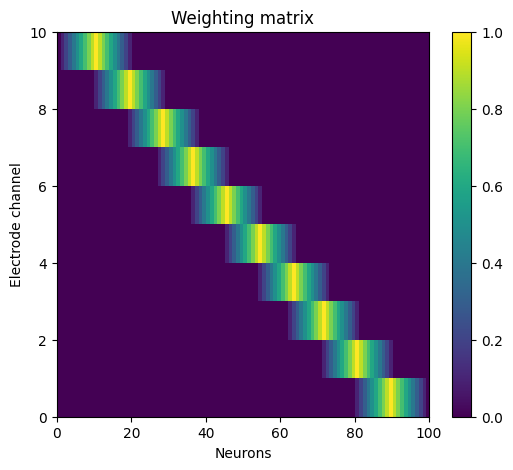

In [53]:
# Multi-neuron version
neurons = 100

# only a simple triangle for the radiation behavior
window = np.concatenate((np.arange(0, 11) / 10, np.arange(9, -1, -1) / 10))

# weighting matrix for radiation behavior (windows per electrode..)
weighting_matrix = np.zeros((n2, neurons))

# index for the middle of the window
middle_idx = np.linspace(len(window) / 2, neurons - len(window) / 2, n2).astype(int)

# set the triangles in the right place in the matrix
for idx in range(n2):
    idx1 = middle_idx[idx] - len(window) // 2
    idx2 = middle_idx[idx] + len(window) // 2
    weighting_matrix[idx, idx1:idx2 + 1] = window
    
# Plot the weighting matrix
fig, ax = plt.subplots(figsize=(6, 5))

ax.set_xlabel('Neurons')
ax.set_ylabel('Electrode channel')
ax.set_title('Weighting matrix')

plt.imshow(weighting_matrix, cmap='viridis', aspect='auto', extent=[0, 100, 0, 10])  # Set extent to control axis limits
plt.colorbar()
plt.show()

Figure 17: Weighting matrix for multi compartment model  


Notice: The calculation below takes a few seconds (40s on my machine) because it calculates 400 differential equations (100 neurons á 4 equations).

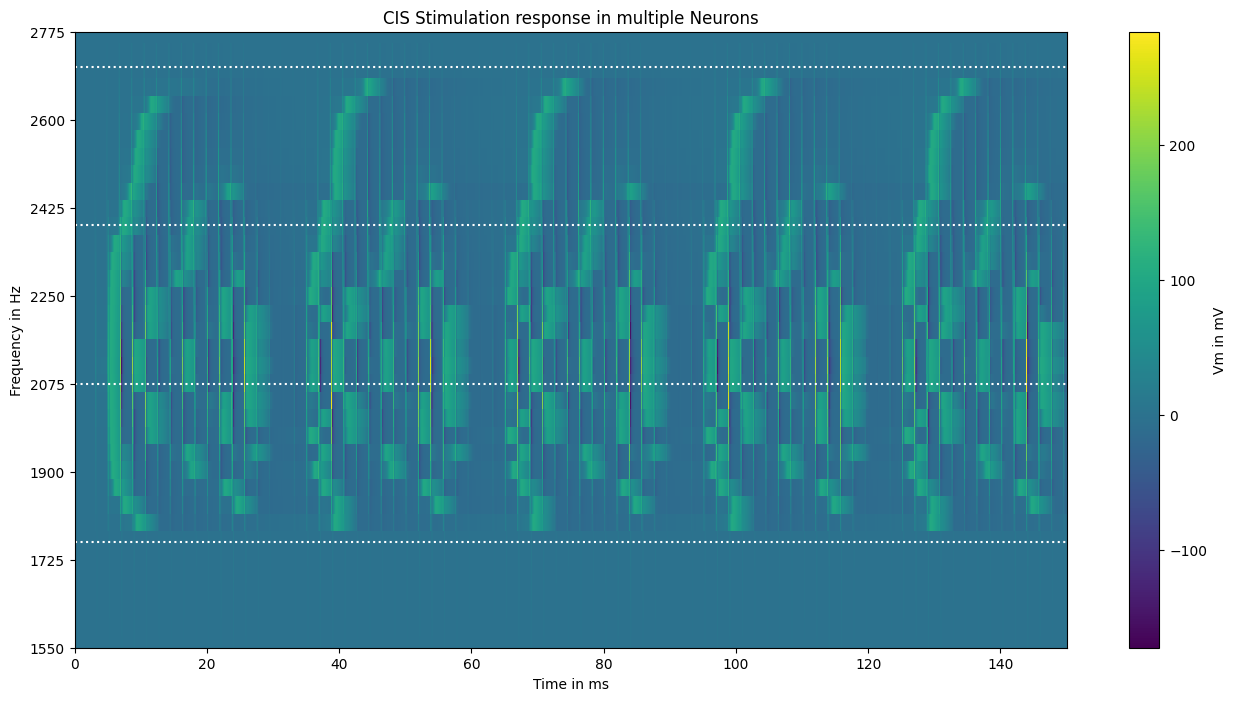

In [54]:
# matrix multiplication (tricky: dimensions/order! only this works!)
final_stim = final_stim * 10  # μA
final_stim = np.dot(weighting_matrix.T, final_stim.T).T

# Extend the simulation time
extended_t_max = 150.0  # Extend the simulation time to 150 ms
num_extended_steps = int(extended_t_max / dt)

# Reinitialize the time vector
t = np.arange(0, extended_t_max, dt)

# Extend the stimulation signals if needed
if len(final_stim) < num_extended_steps:
    final_stim = np.pad(final_stim, (0, num_extended_steps - len(final_stim)), 'linear_ramp')


# prealocation
Vm = np.zeros((n1, neurons))

for channel in range(100):
    Vy = odeint(compute_derivatives, Y0, T, args=(final_stim[:, channel],))
    Vm[:, channel] =Vy[:, 0]

# Plot multi-neuron results
plt.figure(figsize=(16, 8))
plt.imshow(Vm.T, aspect='auto', extent=[t[0], t[-1], 1, neurons], cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(0, neurons, 5), np.arange(500, 4000, 175))
plt.ylabel('Frequency in Hz')
plt.xlabel('Time in ms')
plt.title('CIS Stimulation response in multiple Neurons')

# adds horizontal dots
for idx in middle_idx:
    plt.plot([t[0], t[-1]], [idx, idx], 'w:', linewidth=1.5)

plt.ylim([30, 65])
cbar = plt.colorbar()
cbar.set_label('Vm in mV')

Figure 17: Heatmap of changes in membrane potential due to CIS stimulation in a multi compartment model 

For a given point in time only a handful of cells are active at the same time, the temporal course of Figure 15 can also be seen again. Areas with only low stimulation do not lead to the triggering of action potentials. This pattern of stimulation is transmitted to the spiral ganglia through the cochlea implant, allowing the CI-wearing person to perceive an acoustic representation of the environment. In this case, the signal is very simple and consists only of sinus waves, but a more complex signal can be transmitted with the same underlying algorithm.  
Today's commercial CI manufacturers use this CIS algorithm  


<img src="images/green-divider.png" style="width: 100%;" />
